In [1]:
import warnings
warnings.filterwarnings('ignore')

import urllib, json
from urllib.request import urlopen
import numpy as np
from io import open
import ast
import time
import requests
import pandas as pd

from IPython.core.display import HTML,display
display(HTML("<style>.container { width:85% !important; }</style>"))

%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'


from collections import Counter

import networkx as nx
from itertools import combinations

import random



In [2]:
works = np.load("w_um.npy", allow_pickle=True)
start_year = 2004
end_year = 2008

In [3]:
def build_coauthorship_network(works, institution_name, start_year, end_year):
    """
    Constructs a co-authorship network for the specified time window.
    Nodes represent authors affiliated with the given institution.
    Edges indicate that two authors have collaborated on at least one publication
    within the specified time window, with an optional weight representing
    the number of collaborations.
    """
    G = nx.Graph()
    
    # Iterate through works within the time window
    for work in works:
        pub_year = work["publication_year"]
        if start_year <= pub_year <= end_year:
            authors = []
            for author in work["authorships"]:
                if "institutions" in author:
                    for institution in author["institutions"]:
                        if institution["display_name"] == institution_name:
                            authors.append(author["author"]["display_name"])
                            break  # once matched, no need to check further institutions
            # Only consider works with at least one author from the institution
            unique_authors = set(authors)
            if unique_authors:
                # Add nodes for each author
                for author in unique_authors:
                    G.add_node(author)
                # Add edges between every pair of authors (co-authorship ties)
                for a, b in combinations(unique_authors, 2):
                    if G.has_edge(a, b):
                        G[a][b]['weight'] += 1
                    else:
                        G.add_edge(a, b, weight=1)
    return G

def compute_network_metrics(G):
    """
    Computes a set of network metrics for the given graph G, including:
      - Number of nodes (authors)
      - Number of edges (co-authorship ties)
      - Network density
      - Average degree (number of collaborations per author)
      - Average clustering coefficient (tendency of collaborators to collaborate with each other)
      - Size of the largest connected component (largest cohesive group)
    """
    metrics = {}
    metrics['num_nodes'] = G.number_of_nodes()
    metrics['num_edges'] = G.number_of_edges()
    metrics['density'] = nx.density(G)
    
    # Compute average degree
    if G.number_of_nodes() > 0:
        degrees = dict(G.degree())
        metrics['avg_degree'] = sum(degrees.values()) / G.number_of_nodes()
    else:
        metrics['avg_degree'] = 0
    
    # Compute average clustering coefficient
    metrics['avg_clustering'] = nx.average_clustering(G)
    
    # Compute the largest connected component
    if G.number_of_nodes() > 0:
        # Get all connected components (each as a set of nodes)
        connected_components = list(nx.connected_components(G))
        # Identify the largest connected component by size
        largest_cc = max(connected_components, key=len)
        metrics['largest_cc_size'] = len(largest_cc)
        # Alternatively, you can create a subgraph of the largest connected component:
        largest_cc_subgraph = G.subgraph(largest_cc).copy()
        metrics['largest_cc_subgraph'] = largest_cc_subgraph
    else:
        metrics['largest_cc_size'] = 0
        metrics['largest_cc_subgraph'] = None
        
    return metrics

# Example usage for a 5-year window:
start_year = 2018
end_year = 2023
G_window = build_coauthorship_network(works, "University of Maribor", start_year, end_year)
network_metrics = compute_network_metrics(G_window)

print("Network metrics for {}–{}:".format(start_year, end_year))
for key, value in network_metrics.items():
    if key != 'largest_cc_subgraph':
        print(f"  {key}: {value}")

# Optionally, if you want to analyze the largest connected component further:
largest_cc_graph = network_metrics['largest_cc_subgraph']
if largest_cc_graph:
    print("  The largest connected component has {} nodes.".format(largest_cc_graph.number_of_nodes()))


Network metrics for 2018–2023:
  num_nodes: 3060
  num_edges: 10798
  density: 0.0023071318535041784
  avg_degree: 7.057516339869281
  avg_clustering: 0.6032562017694004
  largest_cc_size: 2356
  The largest connected component has 2356 nodes.


In [4]:
def edge_jaccard_index(G1, G2):
    """
    Computes the Jaccard index for the edge sets of two graphs.
    """
    edges1 = set(G1.edges())
    edges2 = set(G2.edges())
    intersection = edges1.intersection(edges2)
    union = edges1.union(edges2)
    return len(intersection) / len(union) if len(union) > 0 else 0

# Build networks for two consecutive windows
G_window1 = build_coauthorship_network(works, "University of Maribor", 2004, 2005)
G_window2 = build_coauthorship_network(works, "University of Maribor", 2015, 2016)
edge_jacc = edge_jaccard_index(G_window1, G_window2)
print("Edge Jaccard Index for consecutive windows:", edge_jacc)


Edge Jaccard Index for consecutive windows: 0.02497073741708935


In [5]:
G_window = build_coauthorship_network(works, "University of Maribor", start_year, end_year)
network_metrics = compute_network_metrics(G_window)

print("Network metrics for {}–{}:".format(start_year, end_year))
for key, value in network_metrics.items():
    if key != 'largest_cc_subgraph':
        print(f"  {key}: {value}")

# Optionally, if you want to analyze the largest connected component further:
largest_cc_graph = network_metrics['largest_cc_subgraph']
if largest_cc_graph:
    print("  The largest connected component has {} nodes.".format(largest_cc_graph.number_of_nodes()))

Network metrics for 2018–2023:
  num_nodes: 3060
  num_edges: 10798
  density: 0.0023071318535041784
  avg_degree: 7.057516339869281
  avg_clustering: 0.6032562017694004
  largest_cc_size: 2356
  The largest connected component has 2356 nodes.


In [6]:
for year in range(2004, 2019):
    G_window = build_coauthorship_network(works, "University of Maribor", year, year+5)
    network_metrics = compute_network_metrics(G_window)
    print(f"{year}: {network_metrics['largest_cc_size']/network_metrics['num_nodes'], network_metrics['avg_degree'], network_metrics['avg_clustering']}")



2004: (0.6628440366972477, 3.685015290519878, 0.5013247743946363)
2005: (0.6791255289139634, 3.755994358251058, 0.5180674595036716)
2006: (0.6664420485175202, 3.756064690026954, 0.5169526839573563)
2007: (0.6794468887492143, 3.7674418604651163, 0.5201968715132427)
2008: (0.6678424456202234, 4.513815402704291, 0.5315079244049872)
2009: (0.6915367483296214, 4.525612472160357, 0.515412090748123)
2010: (0.7431289640591966, 4.542283298097251, 0.5157865197130893)
2011: (0.7606574216743708, 4.562917308680021, 0.518648902756318)
2012: (0.742238946378175, 4.990592662276576, 0.5416810119674637)
2013: (0.7442781690140845, 5.438380281690141, 0.5498279306590245)
2014: (0.7610921501706485, 5.222696245733788, 0.5487698595267326)
2015: (0.7731668009669621, 5.64867042707494, 0.567029800902214)
2016: (0.7700220426157237, 6.187362233651727, 0.5766571059821402)
2017: (0.768361581920904, 6.887337986041874, 0.6006798981836087)
2018: (0.7699346405228759, 7.057516339869281, 0.6032562017694004)


In [8]:
import community as community_louvain

In [17]:
start_year = 2014
end_year = 2014
G = build_coauthorship_network(works, "University of Maribor", start_year, end_year)

betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

In [13]:
# Compute the best partition
partition = community_louvain.best_partition(G)
# Compute modularity
modularity = community_louvain.modularity(partition, G)
print("Modularity:", modularity)

AttributeError: module 'community' has no attribute 'best_partition'

In [20]:
for year in range(2004, 2024):
    G = build_coauthorship_network(works, "University of Maribor", year, year)
    # get largest connected component as subgraph
    largest_cc = max(nx.connected_components(G), key=len)
    assortativity = nx.degree_assortativity_coefficient(G)
    # assortativity of largest connected component
    assortativity_lc = nx.degree_assortativity_coefficient(G, nodes=largest_cc)
    print(f"{year}: {assortativity}, {assortativity_lc}")

2004: 0.23218355410843167, -0.09013345631683728
2005: 0.17777015608855673, 0.07488213461731386
2006: 0.35818626582846674, -0.021453177048397328
2007: 0.167408616860692, -0.11144453164673859
2008: 0.27865761534059746, -0.3428549951138841
2009: 0.3691621242297637, 0.1698756176520694
2010: 0.1576745566432426, -0.1535344373928414
2011: 0.19465301477301716, -0.1330462778249619
2012: 0.22800229111789275, -0.2523380523380525
2013: 0.9732125161012095, -0.014878067543657203
2014: 0.22887739811756705, 0.21122634323548373
2015: 0.2880235403044652, 0.07448775977028256
2016: 0.13379860923041914, -0.16176521408577255
2017: 0.7261301400304044, 0.06270472508895458
2018: 0.6823445512856143, 0.019144807381567038
2019: 0.323831752419569, 0.15688392619021876
2020: 0.5156628484977677, -0.002044214129193694
2021: 0.7181519245171915, 0.19933031354702643
2022: 0.8068934655241269, 0.4854979166051623
2023: 0.6807488977572549, 0.058138986116791906


In [43]:
start_year = 2018
end_year = start_year+5
G = build_coauthorship_network(works, "University of Maribor", start_year, end_year)
if nx.is_connected(G):
    avg_path_length = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
else:
    # For disconnected networks, compute these metrics on the largest connected component:
    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()
    avg_path_length = nx.average_shortest_path_length(G_lcc)
    diameter = nx.diameter(G_lcc)

print("Average Shortest Path Length:", avg_path_length)
print("Network Diameter:", diameter)


Average Shortest Path Length: 5.631752331311121
Network Diameter: 14


In [27]:
def robustness_simulation(G, centrality_dict, removal_fraction=0.5):
    # Remove the top fraction of nodes by centrality and compute the size of the largest connected component
    num_to_remove = int(removal_fraction * len(centrality_dict))
    sorted_nodes = sorted(centrality_dict, key=centrality_dict.get, reverse=True)
    nodes_to_remove = sorted_nodes[:num_to_remove]
    G_copy = G.copy()
    G_copy.remove_nodes_from(nodes_to_remove)
    if len(G_copy) > 0:
        largest_cc_size = len(max(nx.connected_components(G_copy), key=len))
    else:
        largest_cc_size = 0
    return largest_cc_size

# Example: robustness based on betweenness centrality
G = build_coauthorship_network(works, "University of Maribor", 2004, 2004)
robustness_value = robustness_simulation(G, betweenness)
print("Size of largest connected component after removal:", robustness_value)


Size of largest connected component after removal: 31


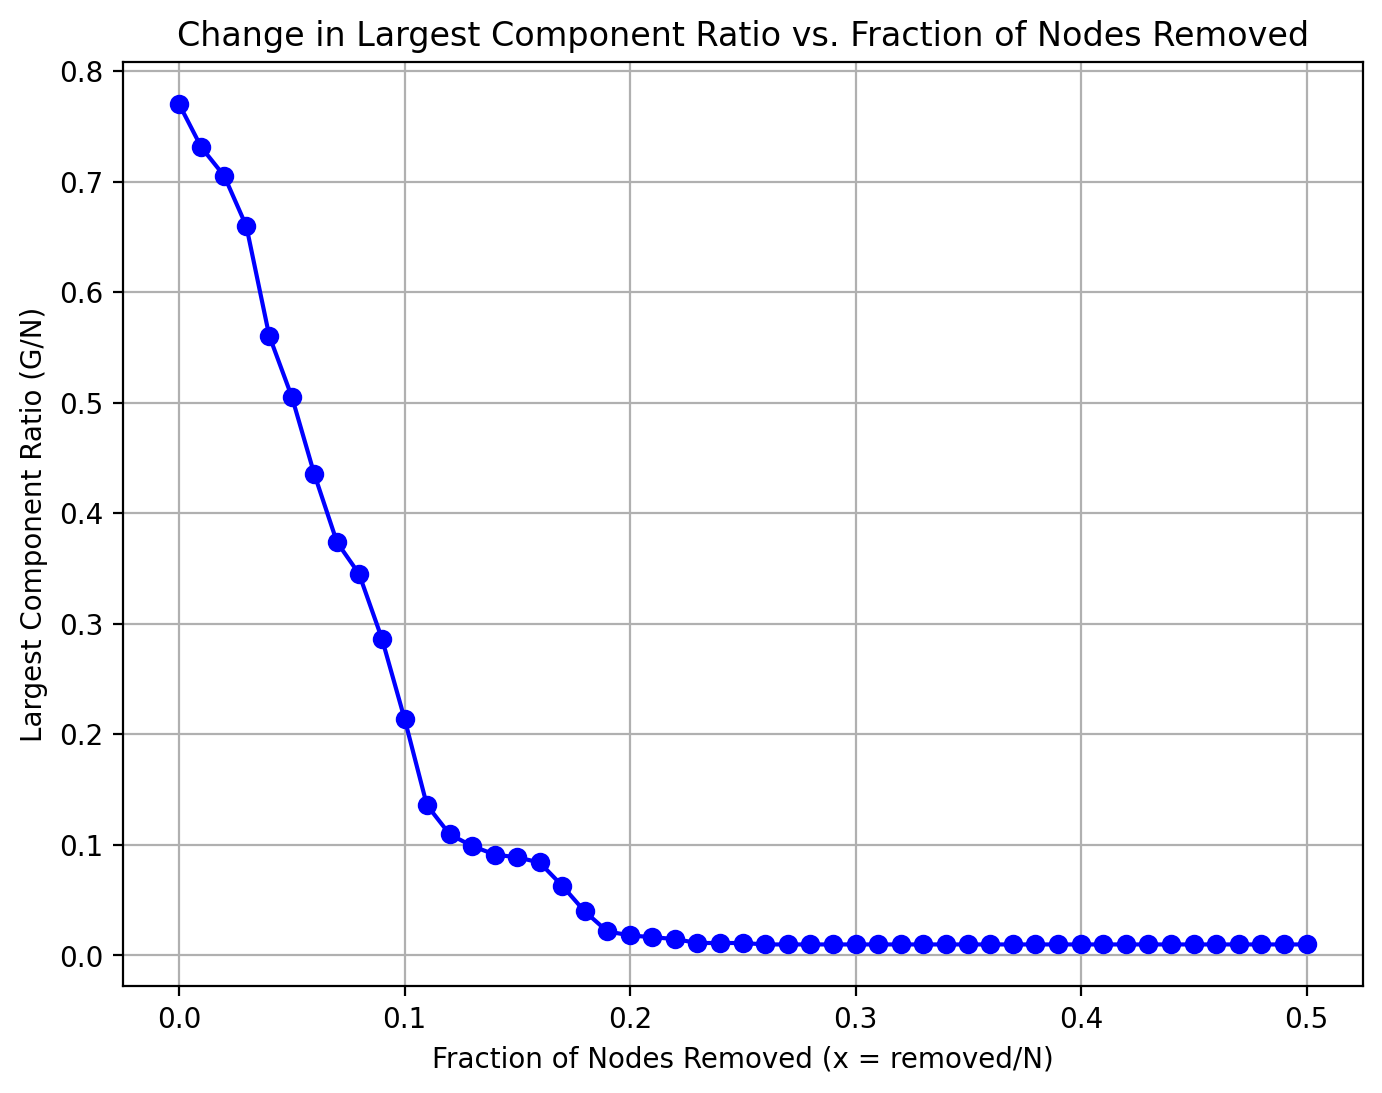

In [44]:
#import networkx as nx
#import matplotlib.pyplot as plt

def simulate_removal_ratio(G, centrality_dict, removal_fractions):
    """
    Simulates the removal of nodes from G based on a centrality measure and computes:
      - The fraction of nodes removed.
      - The ratio of the largest connected component (LCC) size to the original number of nodes.
    
    Parameters:
      G : networkx.Graph
          The original graph.
      centrality_dict : dict
          Dictionary of centrality scores (e.g., betweenness centrality) for nodes.
      removal_fractions : list of float
          List of fractions (between 0 and 1) of the total nodes to remove.
    
    Returns:
      removed_fraction_list : list of float
          The fraction of nodes removed (x-axis values).
      lcc_ratio_list : list of float
          The ratio (LCC size / total nodes) after removals (y-axis values).
    """
    total_nodes = G.number_of_nodes()
    # Sort nodes by centrality (highest first)
    sorted_nodes = sorted(centrality_dict, key=centrality_dict.get, reverse=True)
    
    removed_fraction_list = []
    lcc_ratio_list = []
    
    for frac in removal_fractions:
        # Calculate number of nodes to remove based on the given fraction
        num_to_remove = int(frac * total_nodes)
        removed_fraction_list.append(num_to_remove / total_nodes)
        
        # Create a copy of the graph and remove the top num_to_remove nodes
        G_copy = G.copy()
        nodes_to_remove = sorted_nodes[:num_to_remove]
        G_copy.remove_nodes_from(nodes_to_remove)
        
        # Compute the size of the largest connected component in G_copy
        if G_copy.number_of_nodes() > 0:
            largest_cc = max(nx.connected_components(G_copy), key=len)
            largest_cc_size = len(largest_cc)
        else:
            largest_cc_size = 0
        
        # Compute the ratio of the largest connected component size to the original total nodes
        lcc_ratio = largest_cc_size / total_nodes
        lcc_ratio_list.append(lcc_ratio)
    
    return removed_fraction_list, lcc_ratio_list

# Example usage:
# Build or load your co-authorship network here.
# For demonstration, we'll create a random graph.
# Replace the following with your actual graph (e.g., using build_coauthorship_network).
#G = nx.erdos_renyi_graph(100, 0.05, seed=42)

# Compute a centrality measure. Here, we use betweenness centrality.
centrality = nx.betweenness_centrality(G)

# Define removal fractions (e.g., from 0% to 50% of nodes removed)
removal_fractions = [i/100 for i in range(0, 51)]  # 0%, 1%, ..., 50%

# Run the simulation to get the fraction removed and the ratio of the largest component
removed_fraction, lcc_ratio = simulate_removal_ratio(G, centrality, removal_fractions)

# Plot G/N (ratio of largest connected component) vs. the fraction of nodes removed.
plt.figure(figsize=(8, 6))
plt.plot(removed_fraction, lcc_ratio, marker='o', linestyle='-', color='b')
plt.xlabel("Fraction of Nodes Removed (x = removed/N)")
plt.ylabel("Largest Component Ratio (G/N)")
plt.title("Change in Largest Component Ratio vs. Fraction of Nodes Removed")
plt.grid(True)
plt.show()


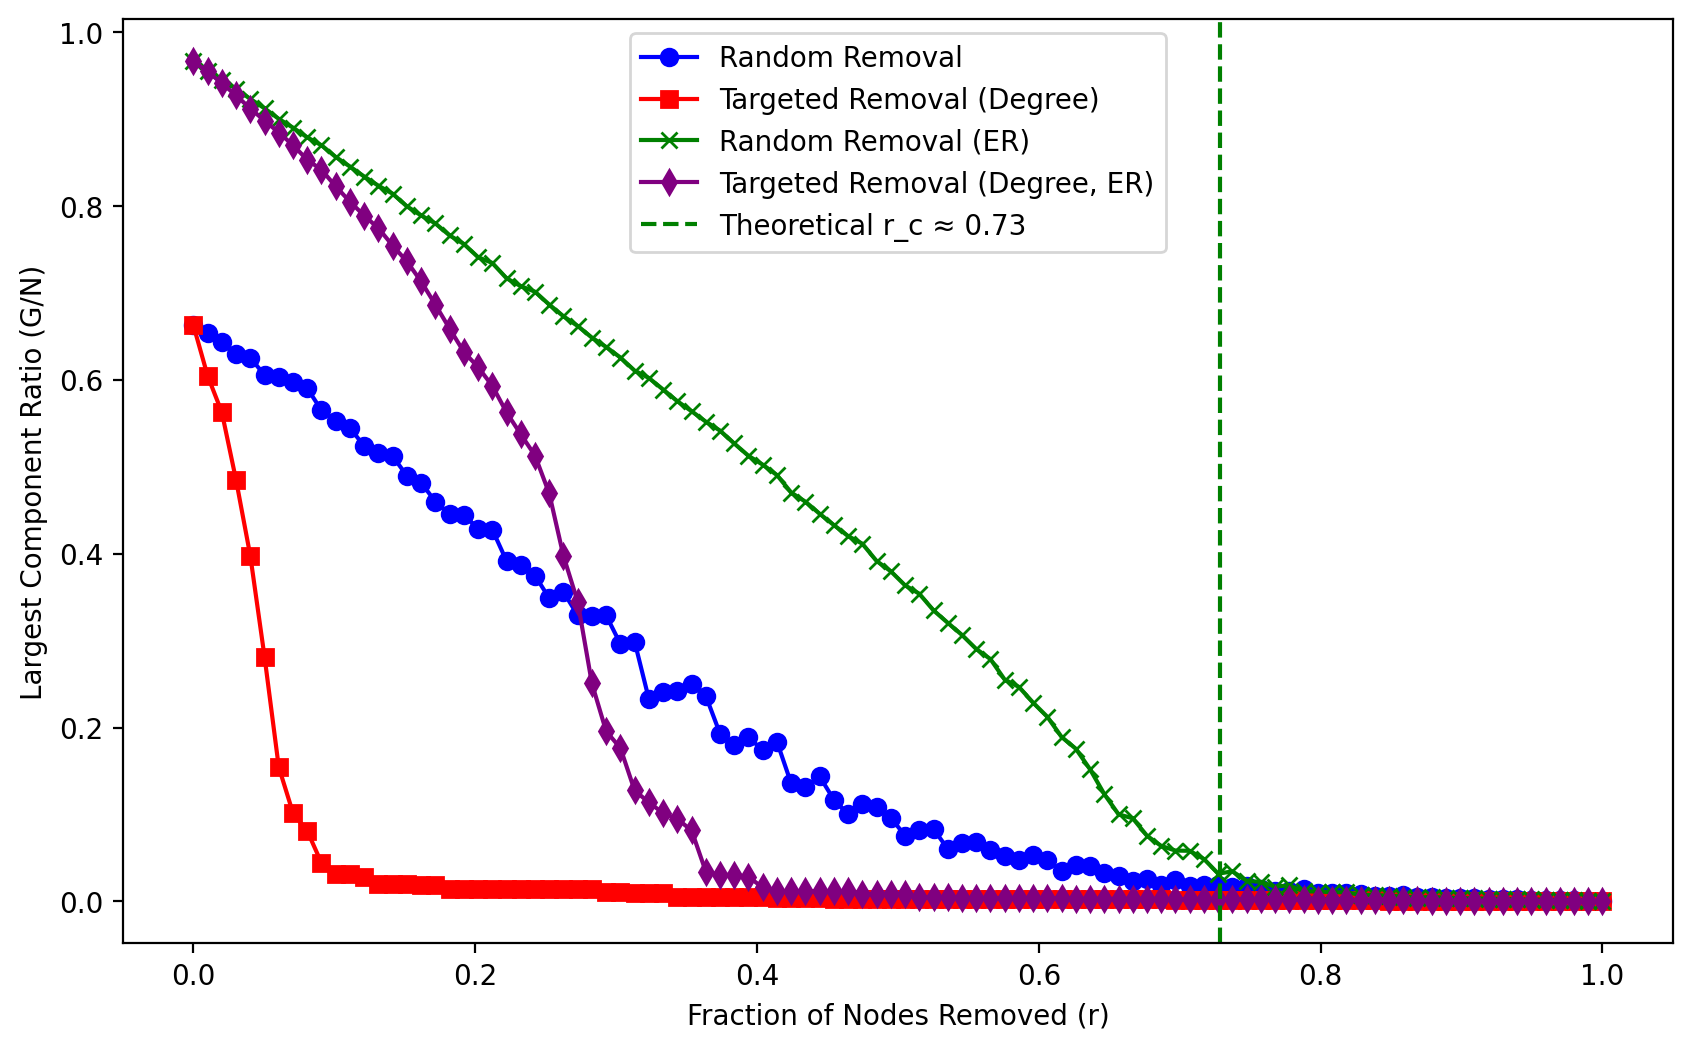

In [139]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

start_year = 2004
end_year = start_year+5
G = build_coauthorship_network(works, "University of Maribor", start_year, end_year)

def simulate_removal_ratio_random(G_original, removal_fractions, num_trials=20, seed=42):
    """
    Simulates random node removal on a given network.
    
    Parameters:
      G_original : networkx.Graph
          The original graph.
      removal_fractions : iterable
          Fractions (between 0 and 1) of nodes to remove.
      num_trials : int
          Number of trials to average over.
      seed : int
          Random seed for reproducibility.
    
    Returns:
      removal_fracs : list of float
          The fraction of nodes removed.
      lcc_ratios : list of float
          The average ratio of the largest connected component (LCC) size to the original number of nodes.
    """
    random.seed(seed)
    np.random.seed(seed)
    
    N = G_original.number_of_nodes()
    removal_fracs = []
    lcc_ratios = []
    
    for r in removal_fractions:
        num_remove = int(r * N)
        removal_fracs.append(r)
        
        trial_ratios = []
        for _ in range(num_trials):
            # Work on a fresh copy for each trial
            G = G_original.copy()
            nodes = list(G.nodes())
            random.shuffle(nodes)
            nodes_to_remove = nodes[:num_remove]
            G.remove_nodes_from(nodes_to_remove)
            
            if G.number_of_nodes() > 0:
                largest_cc = max(nx.connected_components(G), key=len)
                trial_ratios.append(len(largest_cc) / N)
            else:
                trial_ratios.append(0)
        
        lcc_ratios.append(np.mean(trial_ratios))
    
    return removal_fracs, lcc_ratios

def simulate_removal_ratio_targeted(G_original, removal_fractions, centrality_measure='degree'):
    """
    Simulates targeted node removal based on a chosen centrality measure.
    
    Parameters:
      G_original : networkx.Graph
          The original graph.
      removal_fractions : iterable
          Fractions (between 0 and 1) of nodes to remove.
      centrality_measure : str
          Which centrality measure to use ('degree' or 'betweenness'). For an ER network, degree is effective.
    
    Returns:
      removal_fracs : list of float
          The fraction of nodes removed.
      lcc_ratios : list of float
          The ratio of the largest connected component (LCC) size to the original number of nodes.
    """
    N = G_original.number_of_nodes()
    # Compute the chosen centrality measure on the original network.
    if centrality_measure == 'betweenness':
        centrality = nx.betweenness_centrality(G_original)
    else:
        # Default to degree centrality
        centrality = nx.degree_centrality(G_original)
    
    # Sort nodes by centrality (highest first)
    sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)
    
    removal_fracs = []
    lcc_ratios = []
    
    for r in removal_fractions:
        num_remove = int(r * N)
        removal_fracs.append(r)
        
        # Create a copy and remove the top num_remove nodes
        G = G_original.copy()
        nodes_to_remove = sorted_nodes[:num_remove]
        G.remove_nodes_from(nodes_to_remove)
        
        if G.number_of_nodes() > 0:
            largest_cc = max(nx.connected_components(G), key=len)
            lcc_ratio = len(largest_cc) / N
        else:
            lcc_ratio = 0
        lcc_ratios.append(lcc_ratio)
    
    return removal_fracs, lcc_ratios

# --- Set up the ER network parameters ---
N = G.number_of_nodes()
avg_degree = G.number_of_edges() * 2 / N
p_edge = avg_degree / (N - 1)

# Generate the original ER network
seed = 42
G_ER = nx.erdos_renyi_graph(N, p_edge, seed=seed)

# Define removal fractions from 0 to 1 (we use a finer grid to observe the transition clearly)
removal_fractions = np.linspace(0, 1, 100)

# Simulate random removal
r_random, lcc_random = simulate_removal_ratio_random(G, removal_fractions, num_trials=20, seed=seed)
r_random_er, lcc_random_er = simulate_removal_ratio_random(G_ER, removal_fractions, num_trials=20, seed=seed)

# Simulate targeted removal using degree centrality
r_targeted, lcc_targeted = simulate_removal_ratio_targeted(G, removal_fractions, centrality_measure='degree')
r_targeted_er, lcc_targeted_er = simulate_removal_ratio_targeted(G_ER, removal_fractions, centrality_measure='degree')

# Plot the results: Largest component ratio (G/N) vs. fraction of nodes removed (r)
plt.figure(figsize=(10, 6))
plt.plot(r_random, lcc_random, marker='o', linestyle='-', color='blue', label='Random Removal')
plt.plot(r_targeted, lcc_targeted, marker='s', linestyle='-', color='red', label='Targeted Removal (Degree)')
plt.plot(r_random_er, lcc_random_er, marker='x', linestyle='-', color='green', label='Random Removal (ER)')
plt.plot(r_targeted_er, lcc_targeted_er, marker='d', linestyle='-', color='purple', label='Targeted Removal (Degree, ER)')
plt.xlabel("Fraction of Nodes Removed (r)")
plt.ylabel("Largest Component Ratio (G/N)")
#plt.title("Percolation Transition in an ER Network (N=5000, avg_degree=4)")
# Theoretical threshold for random removal: (1-r)*avg_degree = 1  => r ≈ 1 - (1/avg_degree)
r_c = 1 - 1/avg_degree
plt.axvline(x=r_c, color='green', linestyle='--', label=f"Theoretical r_c ≈ {r_c:.2f}")
plt.legend()
#plt.grid(True)
plt.show()


In [205]:
# --- Define functions to estimate threshold ---

def find_threshold_by_size(removal_fracs, lcc_ratios, critical_ratio=0.05):
    """
    Returns the smallest removal fraction r at which the giant component ratio
    falls below a specified critical_ratio.
    """
    for r, ratio in zip(removal_fracs, lcc_ratios):
        if ratio < critical_ratio:
            return r
    return None  # If threshold is not reached

def find_threshold_by_derivative(removal_fracs, lcc_ratios):
    """
    Returns the removal fraction r at which the drop in the giant component ratio 
    (i.e., the derivative) is the steepest.
    """
    differences = np.diff(lcc_ratios)
    index = np.argmin(differences)  # Most negative drop
    return removal_fracs[index]

# --- Estimate thresholds for targeted removal ---
start_year = 2004
end_year = start_year+5
G = build_coauthorship_network(works, "University of Maribor", start_year, end_year)

r_targeted, lcc_targeted = simulate_removal_ratio_targeted(G, removal_fractions, centrality_measure='degree')

threshold_targeted_size = find_threshold_by_size(r_targeted, lcc_targeted, critical_ratio=0.05)
threshold_targeted_deriv = find_threshold_by_derivative(r_targeted, lcc_targeted)

print("Estimated threshold for targeted removal (critical size): r ≈", threshold_targeted_size)
print("Estimated threshold for targeted removal (max drop): r ≈", threshold_targeted_deriv)


Estimated threshold for targeted removal (critical size): r ≈ 0.09090909090909091
Estimated threshold for targeted removal (max drop): r ≈ 0.05050505050505051


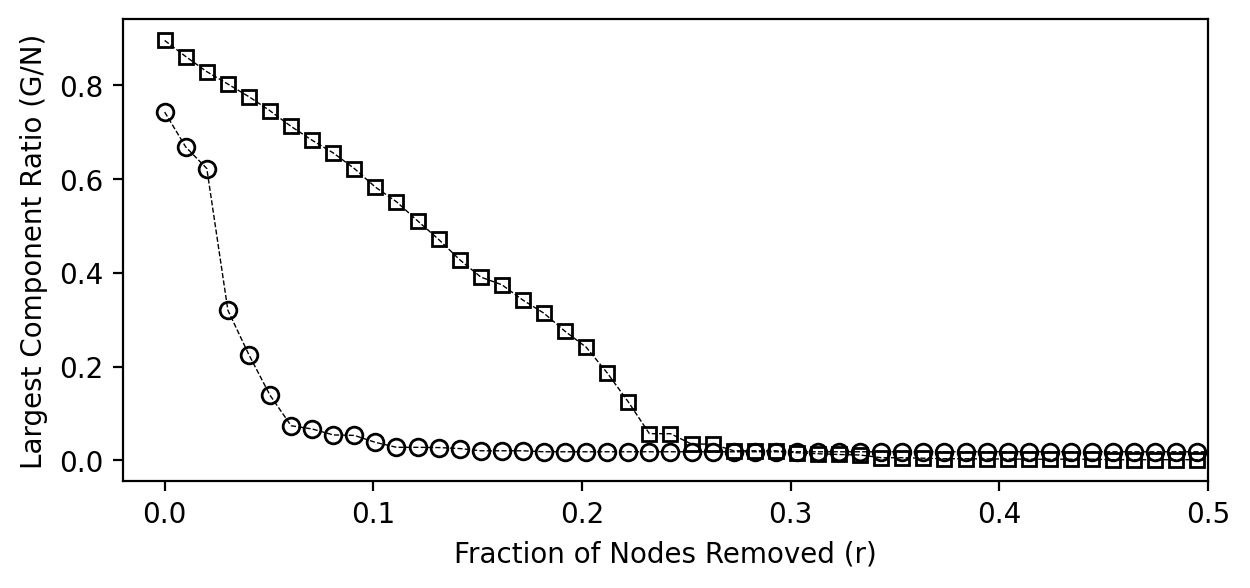

In [219]:
start_year = 2010
end_year = start_year+5
G = build_coauthorship_network(works, "University of Maribor", start_year, end_year)

r_targeted, lcc_targeted = simulate_removal_ratio_targeted(G, removal_fractions, centrality_measure='betweenness')

threshold_targeted_size = find_threshold_by_size(r_targeted, lcc_targeted, critical_ratio=0.05)
threshold_targeted_deriv = find_threshold_by_derivative(r_targeted, lcc_targeted)

#r_ts.append(threshold_targeted_size.tolist())
#r_td.append(threshold_targeted_deriv.tolist())
#print("original network")
#print(f"{end_year}: {threshold_targeted_size.tolist(), threshold_targeted_deriv.tolist()}")

# Create a rewired version of G that preserves the degree sequence.
G_rand = G.copy()
num_edges = G_rand.number_of_edges()
nswap_multiplier = 100  # Number of edge swaps per edge
nswap = nswap_multiplier * num_edges  # e.g., 10 times the number of edges

# Perform the double-edge swap. The double_edge_swap function randomizes the graph
# while preserving the degree sequence.
try:
    nx.double_edge_swap(G_rand, nswap=nswap, max_tries=nswap*10, seed=seed)
except Exception as e:
    print("Double edge swap encountered an error:", e)

r_targeted_rev, lcc_targeted_rev = simulate_removal_ratio_targeted(G_rand, removal_fractions, centrality_measure='betweenness')


# Plot the results: Largest component ratio (G/N) vs. fraction of nodes removed (r)
plt.figure(figsize=(7, 3))
#plt.plot(r_random, lcc_random, marker='o', linestyle='-', color='blue', label='Random Removal')
plt.plot(r_targeted, lcc_targeted, marker='o', linestyle='--', color='black', mfc="none", lw=0.5, ms=6, label='Targeted Removal (Degree)')
plt.plot(r_targeted_rev, lcc_targeted_rev, marker='s', linestyle='--', color='black', mfc="none", lw=0.5, ms=5, label='Targeted Removal (Betweenness)')
#plt.plot(r_random_er, lcc_random_er, marker='x', linestyle='-', color='green', label='Random Removal (ER)')
#plt.plot(r_targeted_er, lcc_targeted_er, marker='d', linestyle='-', color='purple', label='Targeted Removal (Degree, ER)')
plt.xlabel("Fraction of Nodes Removed (r)")
plt.ylabel("Largest Component Ratio (G/N)")
#plt.title("Percolation Transition in an ER Network (N=5000, avg_degree=4)")
# Theoretical threshold for random removal: (1-r)*avg_degree = 1  => r ≈ 1 - (1/avg_degree)
#r_c = 1 - 1/avg_degree
#plt.axvline(x=r_c, color='green', linestyle='--', label=f"Theoretical r_c ≈ {r_c:.2f}")
#plt.legend()
#plt.grid(True)
plt.xlim(-0.02, 0.5)
plt.show()

In [221]:

r_ts = []
r_td = []
r_ts_rev = []
r_td_rev = []
for year in range(2004, 2019):

    start_year = year
    end_year = start_year+5
    G = build_coauthorship_network(works, "University of Maribor", start_year, end_year)

    r_targeted, lcc_targeted = simulate_removal_ratio_targeted(G, removal_fractions, centrality_measure='betweenness')

    threshold_targeted_size = find_threshold_by_size(r_targeted, lcc_targeted, critical_ratio=0.025)
    threshold_targeted_deriv = find_threshold_by_derivative(r_targeted, lcc_targeted)

    r_ts.append(threshold_targeted_size.tolist())
    r_td.append(threshold_targeted_deriv.tolist())
    #print("original network")
    #print(f"{end_year}: {threshold_targeted_size.tolist(), threshold_targeted_deriv.tolist()}")

    # Create a rewired version of G that preserves the degree sequence.
    G_rand = G.copy()
    num_edges = G_rand.number_of_edges()
    nswap_multiplier = 10  # Number of edge swaps per edge
    nswap = nswap_multiplier * num_edges  # e.g., 10 times the number of edges
    
    # Perform the double-edge swap. The double_edge_swap function randomizes the graph
    # while preserving the degree sequence.
    try:
        nx.double_edge_swap(G_rand, nswap=nswap, max_tries=nswap*10, seed=seed)
    except Exception as e:
        print("Double edge swap encountered an error:", e)

    r_targeted, lcc_targeted = simulate_removal_ratio_targeted(G_rand, removal_fractions, centrality_measure='betweenness')

    threshold_targeted_size = find_threshold_by_size(r_targeted, lcc_targeted, critical_ratio=0.025)
    threshold_targeted_deriv = find_threshold_by_derivative(r_targeted, lcc_targeted)

    r_ts_rev.append(threshold_targeted_size.tolist())
    r_td_rev.append(threshold_targeted_deriv.tolist())

    #print("rewired network")
    #print(f"{end_year}: {threshold_targeted_size.tolist(), threshold_targeted_deriv.tolist()}")
    print(end_year, r_ts[-1],r_ts_rev[-1])


2009 0.14141414141414144 0.32323232323232326
2010 0.12121212121212122 0.29292929292929293
2011 0.14141414141414144 0.2828282828282829
2012 0.13131313131313133 0.27272727272727276
2013 0.13131313131313133 0.2828282828282829
2014 0.14141414141414144 0.2828282828282829
2015 0.15151515151515152 0.27272727272727276
2016 0.18181818181818182 0.25252525252525254
2017 0.18181818181818182 0.26262626262626265
2018 0.17171717171717174 0.30303030303030304
2019 0.19191919191919193 0.29292929292929293
2020 0.22222222222222224 0.31313131313131315
2021 0.22222222222222224 0.32323232323232326
2022 0.20202020202020204 0.31313131313131315
2023 0.19191919191919193 0.31313131313131315


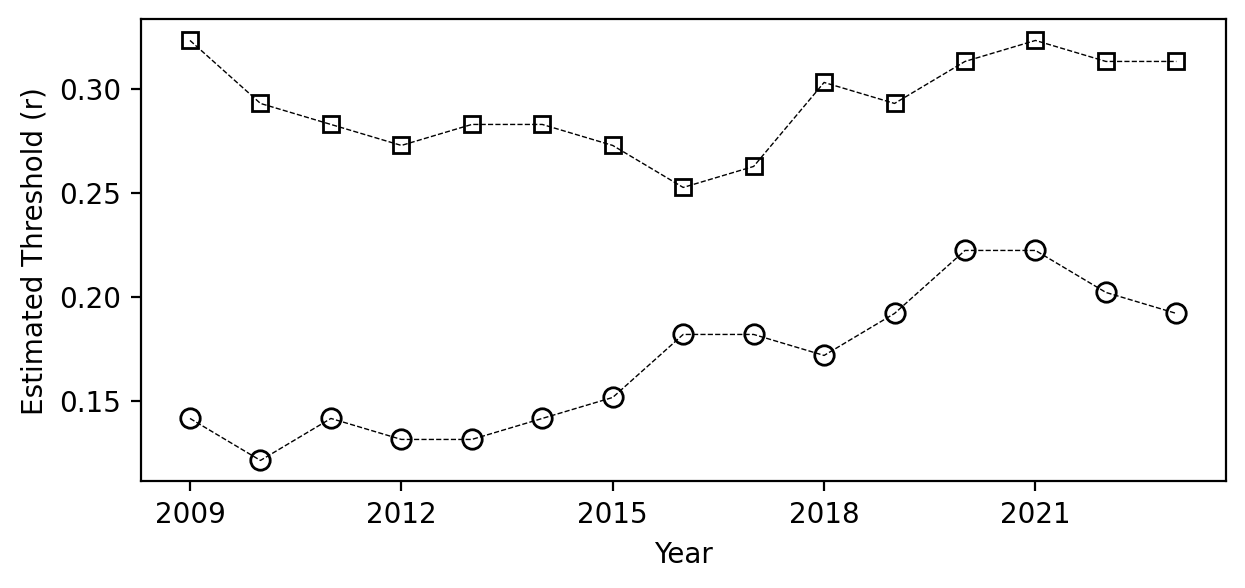

In [223]:
# plot the results
plt.figure(figsize=(7, 3))
plt.plot(range(2009, 2024), r_ts, marker='o', linestyle='--', color='black', mfc="none", ms = 7, lw=0.5, label='Original Network (Critical Size)')
plt.plot(range(2009, 2024), r_ts_rev, marker='s', linestyle='--', color='black', mfc="none", ms = 6, lw=0.5, label='Original Network (Max Drop)')
plt.xlabel("Year")
plt.ylabel("Estimated Threshold (r)")
# x ticks every 2 years
plt.xticks(range(2009, 2023, 3));


In [193]:
r_ts_rev

[0.25252525252525254,
 0.21212121212121213,
 0.21212121212121213,
 0.20202020202020204,
 0.20202020202020204,
 0.20202020202020204,
 0.20202020202020204,
 0.17171717171717174,
 0.22222222222222224,
 0.24242424242424243,
 0.24242424242424243,
 0.25252525252525254,
 0.2828282828282829,
 0.26262626262626265,
 0.27272727272727276]

In [67]:
start_year = 2023
end_year = start_year
G = build_coauthorship_network(works, "University of Maribor", start_year, end_year)

def compute_small_world_sigma(G, seed=42):
    """
    Computes the small-world coefficient sigma for a given network G.
    
    sigma is defined as:
        sigma = (C / C_rand) / (L / L_rand)
    where C and L are the average clustering coefficient and average shortest path length
    of the network G, and C_rand and L_rand are those for a random network of similar size and density.
    
    Parameters:
      G : networkx.Graph
          The network to analyze.
      seed : int
          Random seed for generating the random network.
    
    Returns:
      sigma : float
          The small-world coefficient.
      C : float
          Average clustering coefficient of G.
      L : float
          Average shortest path length of G (computed on the largest connected component if not connected).
      C_rand : float
          Average clustering coefficient of the random network.
      L_rand : float
          Average shortest path length of the random network.
    """
    # Compute average clustering coefficient of G
    C = nx.average_clustering(G)
    
    # Compute average shortest path length on the largest connected component (LCC)
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G_lcc = G.subgraph(largest_cc).copy()
        L = nx.average_shortest_path_length(G_lcc)
    else:
        L = nx.average_shortest_path_length(G)
    
    # Generate an equivalent random network: an ER graph with the same number of nodes and edges.
    N = G.number_of_nodes()
    M = G.number_of_edges()
    # For an undirected network, the edge probability p is:
    p_edge = (2 * M) / (N * (N - 1))
    
    # Create the random network using the same seed for reproducibility
    G_rand = nx.erdos_renyi_graph(N, p_edge, seed=seed)
    
    # Compute the clustering coefficient and average shortest path for the random network
    C_rand = nx.average_clustering(G_rand)
    if not nx.is_connected(G_rand):
        largest_cc_rand = max(nx.connected_components(G_rand), key=len)
        G_rand_lcc = G_rand.subgraph(largest_cc_rand).copy()
        L_rand = nx.average_shortest_path_length(G_rand_lcc)
    else:
        L_rand = nx.average_shortest_path_length(G_rand)
    
    # Compute the small-world coefficient sigma
    sigma = (C / C_rand) / (L / L_rand)
    
    return sigma, C, L, C_rand, L_rand

# --- Example usage ---
# Build an ER network as before.
N = G.number_of_nodes()
avg_degree = G.number_of_edges() * 2 / N
p_edge = avg_degree / (N - 1)
seed = 42

G_ER = nx.erdos_renyi_graph(N, p_edge, seed=seed)

# Compute the small world measure for the ER network
sigma, C, L, C_rand, L_rand = compute_small_world_sigma(G, seed=seed)



print("Small-world coefficient sigma: {:.3f}".format(sigma))
print("Average clustering coefficient of G: {:.4f}".format(C))
print("Average shortest path length of G: {:.4f}".format(L))
print("Average clustering coefficient of G_rand: {:.4f}".format(C_rand))
print("Average shortest path length of G_rand: {:.4f}".format(L_rand))


Small-world coefficient sigma: 262.793
Average clustering coefficient of G: 0.5853
Average shortest path length of G: 4.7665
Average clustering coefficient of G_rand: 0.0022
Average shortest path length of G_rand: 4.7541


In [65]:
import networkx as nx
import numpy as np
import random

def compute_small_world_sigma_rewired(G, nswap_multiplier=10, seed=42):
    """
    Computes the small-world coefficient sigma for a given network G,
    using a rewired version of G (via double-edge swap) as the randomized counterpart.
    
    The small-world coefficient is defined as:
        sigma = (C / C_rand) / (L / L_rand)
    where:
      - C and L are the average clustering coefficient and average shortest path length
        of the original network (or its largest connected component if not connected).
      - C_rand and L_rand are those for the rewired version of G.
      
    Parameters:
      G : networkx.Graph
          The input graph.
      nswap_multiplier : int, optional (default=10)
          The number of swaps performed will be nswap_multiplier * (number of edges in G).
      seed : int, optional (default=42)
          Random seed for reproducibility.
    
    Returns:
      sigma : float
          The small-world coefficient.
      C : float
          Average clustering coefficient of G.
      L : float
          Average shortest path length of G (computed on the largest connected component if not connected).
      C_rand : float
          Average clustering coefficient of the rewired (randomized) network.
      L_rand : float
          Average shortest path length of the rewired network.
    """
    # Ensure reproducibility
    random.seed(seed)
    np.random.seed(seed)
    
    # Compute clustering coefficient (C) and average shortest path length (L) for G.
    C = nx.average_clustering(G)
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G_lcc = G.subgraph(largest_cc).copy()
        L = nx.average_shortest_path_length(G_lcc)
    else:
        L = nx.average_shortest_path_length(G)
    
    # Create a rewired version of G that preserves the degree sequence.
    G_rand = G.copy()
    num_edges = G_rand.number_of_edges()
    nswap = nswap_multiplier * num_edges  # e.g., 10 times the number of edges
    
    # Perform the double-edge swap. The double_edge_swap function randomizes the graph
    # while preserving the degree sequence.
    try:
        nx.double_edge_swap(G_rand, nswap=nswap, max_tries=nswap*10, seed=seed)
    except Exception as e:
        print("Double edge swap encountered an error:", e)
    
    # Compute clustering and average shortest path for the randomized network.
    C_rand = nx.average_clustering(G_rand)
    if not nx.is_connected(G_rand):
        largest_cc_rand = max(nx.connected_components(G_rand), key=len)
        G_rand_lcc = G_rand.subgraph(largest_cc_rand).copy()
        L_rand = nx.average_shortest_path_length(G_rand_lcc)
    else:
        L_rand = nx.average_shortest_path_length(G_rand)
    
    # Compute the small-world coefficient sigma.
    sigma = (C / C_rand) / (L / L_rand)
    
    return sigma, C, L, C_rand, L_rand

# --- Example usage ---
# For demonstration, we use an ER network as an example input.
# In practice, you would replace this with your actual network.
N = 5000
avg_degree = 4
p_edge = avg_degree / (N - 1)
seed = 42

G_ER = nx.erdos_renyi_graph(N, p_edge, seed=seed)

sigma, C, L, C_rand, L_rand = compute_small_world_sigma_rewired(G, nswap_multiplier=1000, seed=seed)

print("Small-world coefficient sigma: {:.3f}".format(sigma))
print("Average clustering coefficient of G: {:.4f}".format(C))
print("Average shortest path length of G: {:.4f}".format(L))
print("Average clustering coefficient of rewired G: {:.4f}".format(C_rand))
print("Average shortest path length of rewired G: {:.4f}".format(L_rand))


Small-world coefficient sigma: 36.538
Average clustering coefficient of G: 0.5853
Average shortest path length of G: 4.7665
Average clustering coefficient of rewired G: 0.0132
Average shortest path length of rewired G: 3.9267


In [241]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt

def compute_metrics(G):
    """
    Computes several metrics for a network G.
    If G is not connected, metrics are computed on its largest connected component.
    
    Returns:
      clustering: Average clustering coefficient.
      L: Average shortest path length (computed on the largest connected component).
      diameter: Diameter of the largest connected component.
    """
    # If not connected, work with the largest connected component
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G_lcc = G.subgraph(largest_cc).copy()
    else:
        G_lcc = G

    clustering = nx.average_clustering(G)
    L = nx.average_shortest_path_length(G_lcc)
    diameter = nx.diameter(G_lcc)
    
    return clustering, L, diameter

def rewire_network(G, nswap_multiplier=10, seed=42):
    """
    Creates a rewired version of G by performing a double-edge swap,
    which randomizes the network while preserving the degree sequence.
    
    Parameters:
      G: The original network (NetworkX Graph).
      nswap_multiplier: Determines the number of swaps as (nswap_multiplier * number_of_edges).
      seed: Random seed for reproducibility.
    
    Returns:
      G_rand: The rewired (randomized) network.
    """
    G_rand = G.copy()
    num_edges = G_rand.number_of_edges()
    nswap = nswap_multiplier * num_edges
    try:
        nx.double_edge_swap(G_rand, nswap=nswap, max_tries=nswap * 10, seed=seed)
    except Exception as e:
        print("Double edge swap encountered an error:", e)
    return G_rand

# --- Example Usage ---

# 1. Create a sample network.
# Here we generate an Erdős–Rényi network for demonstration.
N = 1000
p = 0.01  # Adjust p so that the network is sparse enough to have interesting structure
seed = 42
#G = nx.erdos_renyi_graph(N, p, seed=seed)

year = 2020
G = build_coauthorship_network(works, "University of Maribor", year, year)

# 2. Compute metrics for the original network.
clust_orig, L_orig, diam_orig = compute_metrics(G)

# 3. Create a rewired version that preserves the degree sequence.
nm = .5
G_rand = rewire_network(G, nswap_multiplier=nm, seed=seed)

# 4. Compute metrics for the rewired network.
clust_rand, L_rand, diam_rand = compute_metrics(G_rand)

# 5. Print and compare the metrics.
print("Original Network Metrics:")
print("  Average Clustering Coefficient: {:.4f}".format(clust_orig))
print("  Average Shortest Path Length (LCC): {:.4f}".format(L_orig))
print("  Diameter (LCC): {}".format(diam_orig))
print("\nRewired Network Metrics (Degree-preserving randomization):")
print("  Average Clustering Coefficient: {:.4f}".format(clust_rand))
print("  Average Shortest Path Length (LCC): {:.4f}".format(L_rand))
print("  Diameter (LCC): {}".format(diam_rand))

# 6. Optionally, compare degree distributions to confirm they are preserved.
deg_orig = [d for _, d in G.degree()]
deg_rand = [d for _, d in G_rand.degree()];
"""
plt.figure(figsize=(10, 5))
plt.hist(deg_orig, bins=range(max(deg_orig)+1), label="Original", histtype='step')
plt.hist(deg_rand, bins=range(max(deg_rand)+1), label="Rewired", histtype='step', linestyle='dashed')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.title("Degree Distribution Comparison (should be similar)")
plt.show();
"""

Original Network Metrics:
  Average Clustering Coefficient: 0.5948
  Average Shortest Path Length (LCC): 7.5685
  Diameter (LCC): 22

Rewired Network Metrics (Degree-preserving randomization):
  Average Clustering Coefficient: 0.0353
  Average Shortest Path Length (LCC): 4.3837
  Diameter (LCC): 10


'\nplt.figure(figsize=(10, 5))\nplt.hist(deg_orig, bins=range(max(deg_orig)+1), label="Original", histtype=\'step\')\nplt.hist(deg_rand, bins=range(max(deg_rand)+1), label="Rewired", histtype=\'step\', linestyle=\'dashed\')\nplt.xlabel("Degree")\nplt.ylabel("Frequency")\nplt.legend()\nplt.title("Degree Distribution Comparison (should be similar)")\nplt.show();\n'

In [75]:
# list G properties, do not use nx.info
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
print("Density:", nx.density(G))
print("Is connected?", nx.is_connected(G))
print("Average Clustering Coefficient:", nx.average_clustering(G))



Nodes: 1134
Edges: 2627
Density: 0.00408928240643451
Is connected? False
Average Clustering Coefficient: 0.5852889085283822


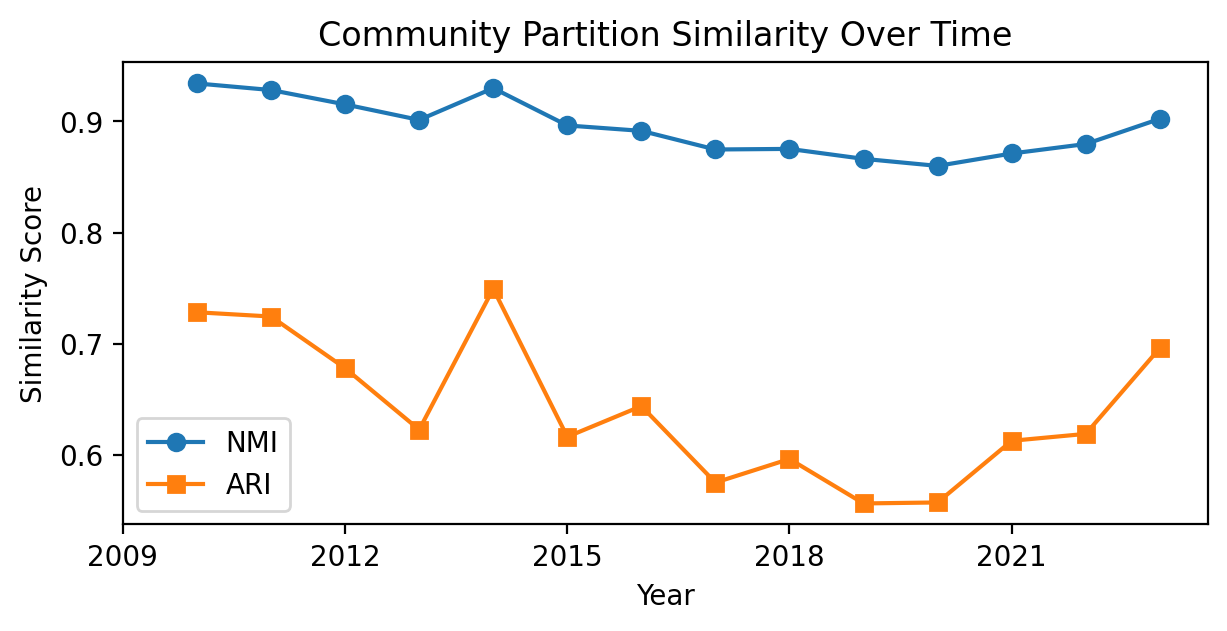

'\n# ----------------------------\n# 4. Build Data for an Alluvial / Sankey Diagram of Community Evolution\n# ----------------------------\n# For each snapshot, build a mapping from community to its set of nodes.\ncommunity_nodes = []\nfor t, partition in enumerate(partitions):\n    comm_dict = {}\n    for node, comm in partition.items():\n        comm_dict.setdefault(comm, set()).add(node)\n    community_nodes.append(comm_dict)\n\n# Build the list of Sankey diagram nodes.\n# Each node label will be of the form "t{t}_{year}_c{comm}".\nsankey_nodes = []\nnode_indices = {}  # maps (snapshot, community) to an index in sankey_nodes\nfor t, comm_dict in enumerate(community_nodes):\n    for comm in comm_dict:\n        label = f"t{t}_{2004+t}_c{comm}"\n        node_indices[(t, comm)] = len(sankey_nodes)\n        sankey_nodes.append(label)\n\n# Build the links between communities in successive snapshots.\nsources = []\ntargets = []\nvalues = []\nfor t in range(n_snapshots - 1):\n    comm_dict_

In [107]:
import community.community_louvain as community_louvain  # from python-louvain
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'browser'

# ----------------------------
# 1. Prepare Snapshots for Community Detection
# ----------------------------
# (Assuming build_coauthorship_network(works, "University of Maribor", start_year, end_year)
#  is defined and works/works data is available.)

snapshots = []
# Example: load some additional data if needed
w_um = np.load('w_um.npy', allow_pickle=True)  # if needed for your build_coauthorship_network
for year in range(2004, 2019):
    # Build a snapshot for each year (adjust the call as needed)
    G = build_coauthorship_network(works, "University of Maribor", year, year+5)
    snapshots.append(G)

n_snapshots = len(snapshots)
#print(f"Prepared {n_snapshots} snapshots.")

# ----------------------------
# 2. Compute Community Partitions for Each Snapshot Using Louvain
# ----------------------------
# Each partition is a dictionary mapping node -> community label.
partitions = []
for t, G in enumerate(snapshots):
    partition = community_louvain.best_partition(G)
    partitions.append(partition)
    n_comms = len(set(partition.values()))
    #print(f"Snapshot {t} ({2004+t}): {n_comms} communities detected.")

# ----------------------------
# 3. Compute Similarity Measures (NMI and ARI) Between Successive Snapshots
# ----------------------------
nmi_values = []
ari_values = []
for t in range(n_snapshots - 1):
    # Get the set of nodes in snapshot t and t+1
    nodes_t = set(partitions[t].keys())
    nodes_t1 = set(partitions[t+1].keys())
    common_nodes = nodes_t.intersection(nodes_t1)
    if not common_nodes:
        #print(f"No common nodes between snapshot {t} and {t+1}. Skipping similarity computation.")
        continue
    nodes_sorted = sorted(common_nodes)
    labels_t = [partitions[t][node] for node in nodes_sorted]
    labels_t1 = [partitions[t+1][node] for node in nodes_sorted]
    nmi = normalized_mutual_info_score(labels_t, labels_t1)
    ari = adjusted_rand_score(labels_t, labels_t1)
    nmi_values.append(nmi)
    ari_values.append(ari)
    #print(f"Similarity between snapshot {t} and {t+1}: NMI = {nmi:.3f}, ARI = {ari:.3f}")

# Plot the evolution of NMI and ARI
plt.figure(figsize=(7, 3))
xlab = [year + 5 for year in range(2005, 2019)]
plt.plot(xlab, nmi_values, marker='o', label="NMI")
plt.plot(xlab, ari_values, marker='s', label="ARI")
# x ticks only for every 3 years
plt.xticks(np.arange(2009, 2024, 3));
plt.xlabel("Year")
plt.ylabel("Similarity Score")
plt.title("Community Partition Similarity Over Time")
plt.legend()
#plt.grid(True)
plt.show()


"""
# ----------------------------
# 4. Build Data for an Alluvial / Sankey Diagram of Community Evolution
# ----------------------------
# For each snapshot, build a mapping from community to its set of nodes.
community_nodes = []
for t, partition in enumerate(partitions):
    comm_dict = {}
    for node, comm in partition.items():
        comm_dict.setdefault(comm, set()).add(node)
    community_nodes.append(comm_dict)

# Build the list of Sankey diagram nodes.
# Each node label will be of the form "t{t}_{year}_c{comm}".
sankey_nodes = []
node_indices = {}  # maps (snapshot, community) to an index in sankey_nodes
for t, comm_dict in enumerate(community_nodes):
    for comm in comm_dict:
        label = f"t{t}_{2004+t}_c{comm}"
        node_indices[(t, comm)] = len(sankey_nodes)
        sankey_nodes.append(label)

# Build the links between communities in successive snapshots.
sources = []
targets = []
values = []
for t in range(n_snapshots - 1):
    comm_dict_t = community_nodes[t]
    comm_dict_t1 = community_nodes[t+1]
    for comm_t, nodes_t in comm_dict_t.items():
        for comm_t1, nodes_t1 in comm_dict_t1.items():
            # Calculate the flow as the count of common nodes between communities in successive snapshots.
            flow = len(nodes_t.intersection(nodes_t1))
            if flow > 0:
                source = node_indices[(t, comm_t)]
                target = node_indices[(t+1, comm_t1)]
                sources.append(source)
                targets.append(target)
                values.append(flow)



# ----------------------------
# 5. Plot the Sankey Diagram using Plotly
# ----------------------------
sankey_fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        #label=sankey_nodes,
        color="blue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

sankey_fig.update_layout(title_text="Community Evolution Sankey Diagram", font_size=10)
sankey_fig.show()
"""

In [130]:
ari_ = []
nmi_ = []
for rep in range(100): 
    xlab = []
    snapshots = []
    # Example: load some additional data if needed
    #w_um = np.load('w_um.npy', allow_pickle=True)  # if needed for your build_coauthorship_network
    for year in range(2004, 2019):
        xlab.append(year+5)
        # Build a snapshot for each year (adjust the call as needed)
        G = build_coauthorship_network(works, "University of Maribor", year, year+5)
        snapshots.append(G)

    n_snapshots = len(snapshots)
    #print(f"Prepared {n_snapshots} snapshots.")

    # ----------------------------
    # 2. Compute Community Partitions for Each Snapshot Using Louvain
    # ----------------------------
    # Each partition is a dictionary mapping node -> community label.
    partitions = []
    for t, G in enumerate(snapshots):
        partition = community_louvain.best_partition(G)
        partitions.append(partition)
        n_comms = len(set(partition.values()))
        #print(f"Snapshot {t} ({2004+t}): {n_comms} communities detected.")

    # ----------------------------
    # 3. Compute Similarity Measures (NMI and ARI) Between Successive Snapshots
    # ----------------------------
    nmi_values = []
    ari_values = []
    for t in range(n_snapshots - 1):
        # Get the set of nodes in snapshot t and t+1
        nodes_t = set(partitions[t].keys())
        nodes_t1 = set(partitions[t+1].keys())
        common_nodes = nodes_t.intersection(nodes_t1)
        if not common_nodes:
            #print(f"No common nodes between snapshot {t} and {t+1}. Skipping similarity computation.")
            continue
        nodes_sorted = sorted(common_nodes)
        labels_t = [partitions[t][node] for node in nodes_sorted]
        labels_t1 = [partitions[t+1][node] for node in nodes_sorted]
        nmi = normalized_mutual_info_score(labels_t, labels_t1)
        ari = adjusted_rand_score(labels_t, labels_t1)
        nmi_values.append(nmi)
        ari_values.append(ari)
        #print(f"Similarity between snapshot {t} and {t+1}: NMI = {nmi:.3f}, ARI = {ari:.3f}")#
    ari_.append(ari_values)
    nmi_.append(nmi_values)

In [133]:
jaccard_values = np.load('jaccard_um.npy')

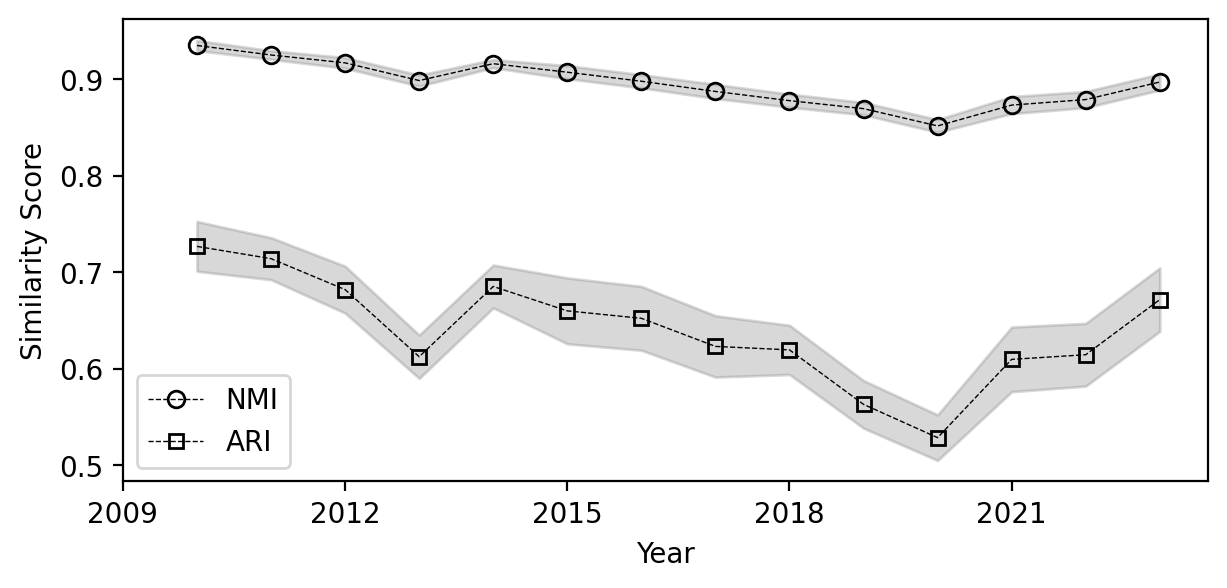

In [137]:
mean_ari = np.mean(ari_, axis=0)
mean_nmi = np.mean(nmi_, axis=0)
sd_ari = np.std(ari_, axis=0)
sd_nmi = np.std(nmi_, axis=0)

plt.figure(figsize=(7, 3))
plt.plot(xlab[1:], mean_nmi, marker='o', label="NMI", color='black', linestyle='--', linewidth=0.5, markersize=6, mfc='None')
plt.plot(xlab[1:], mean_ari, marker='s', label="ARI", color='black', linestyle='--', linewidth=0.5, markersize=5, mfc='None')
# plot standard deviation as grey area
plt.fill_between(xlab[1:], mean_nmi - sd_nmi, mean_nmi + sd_nmi, color='grey', alpha=0.3)
plt.fill_between(xlab[1:], mean_ari - sd_ari, mean_ari + sd_ari, color='grey', alpha=0.3)
#plt.plot(xlab, jaccard_values, marker='x', label="Jaccard", color='black', linestyle='-', linewidth=0.5, markersize=5, mfc='None')
# x ticks only for every 3 years
plt.xticks(np.arange(2009, 2024, 3));
plt.xlabel("Year")
plt.ylabel("Similarity Score")
#plt.title("Community Partition Similarity Over Time")
plt.legend()
#plt.grid(True)
plt.show()

In [224]:

ari_rand = []
nmi_rand = []
for rep in range(100): 
    xlab = []
    snapshots = []
    # Example: load some additional data if needed
    #w_um = np.load('w_um.npy', allow_pickle=True)  # if needed for your build_coauthorship_network
    for year in range(2004, 2019):
        xlab.append(year+5)
        # Build a snapshot for each year (adjust the call as needed)
        G = build_coauthorship_network(works, "University of Maribor", year, year+5)
        G_rand = rewire_network(G, nswap_multiplier=10, seed=seed)
        snapshots.append(G_rand)

    n_snapshots = len(snapshots)
    #print(f"Prepared {n_snapshots} snapshots.")

    # ----------------------------
    # 2. Compute Community Partitions for Each Snapshot Using Louvain
    # ----------------------------
    # Each partition is a dictionary mapping node -> community label.
    partitions = []
    for t, G in enumerate(snapshots):
        partition = community_louvain.best_partition(G)
        partitions.append(partition)
        n_comms = len(set(partition.values()))
        #print(f"Snapshot {t} ({2004+t}): {n_comms} communities detected.")

    # ----------------------------
    # 3. Compute Similarity Measures (NMI and ARI) Between Successive Snapshots
    # ----------------------------
    nmi_values = []
    ari_values = []
    for t in range(n_snapshots - 1):
        # Get the set of nodes in snapshot t and t+1
        nodes_t = set(partitions[t].keys())
        nodes_t1 = set(partitions[t+1].keys())
        common_nodes = nodes_t.intersection(nodes_t1)
        if not common_nodes:
            #print(f"No common nodes between snapshot {t} and {t+1}. Skipping similarity computation.")
            continue
        nodes_sorted = sorted(common_nodes)
        labels_t = [partitions[t][node] for node in nodes_sorted]
        labels_t1 = [partitions[t+1][node] for node in nodes_sorted]
        nmi = normalized_mutual_info_score(labels_t, labels_t1)
        ari = adjusted_rand_score(labels_t, labels_t1)
        nmi_values.append(nmi)
        ari_values.append(ari)
        #print(f"Similarity between snapshot {t} and {t+1}: NMI = {nmi:.3f}, ARI = {ari:.3f}")#
    ari_rand.append(ari_values)
    nmi_rand.append(nmi_values)

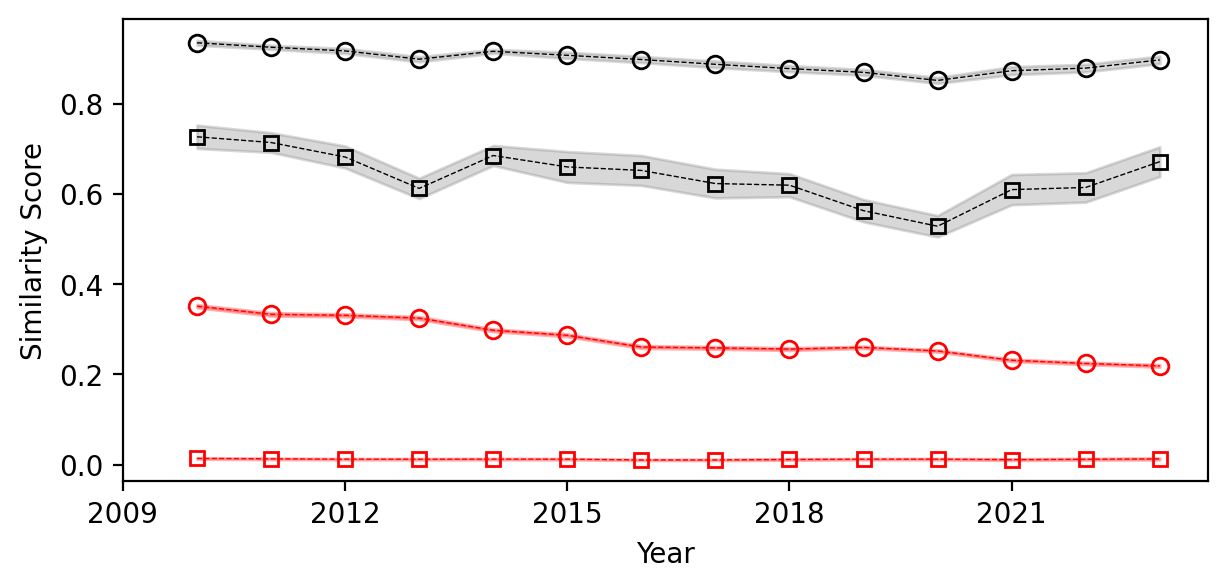

In [227]:
mean_ari = np.mean(ari_, axis=0)
mean_nmi = np.mean(nmi_, axis=0)
sd_ari = np.std(ari_, axis=0)
sd_nmi = np.std(nmi_, axis=0)
mean_ari_rand = np.mean(ari_rand, axis=0)
mean_nmi_rand = np.mean(nmi_rand, axis=0)
sd_ari_rand = np.std(ari_rand, axis=0)
sd_nmi_rand = np.std(nmi_rand, axis=0)

plt.figure(figsize=(7, 3))
plt.plot(xlab[1:], mean_nmi, marker='o', label="NMI", color='black', linestyle='--', linewidth=0.5, markersize=6, mfc='None')
plt.plot(xlab[1:], mean_ari, marker='s', label="ARI", color='black', linestyle='--', linewidth=0.5, markersize=5, mfc='None')
plt.plot(xlab[1:], mean_nmi_rand, marker='o', label="NMI (Random)", color='red', linestyle='--', linewidth=0.5, markersize=6, mfc='None')
plt.plot(xlab[1:], mean_ari_rand, marker='s', label="ARI (Random)", color='red', linestyle='--', linewidth=0.5, markersize=5, mfc='None')
# plot standard deviation as grey area
plt.fill_between(xlab[1:], mean_nmi - sd_nmi, mean_nmi + sd_nmi, color='grey', alpha=0.3)
plt.fill_between(xlab[1:], mean_ari - sd_ari, mean_ari + sd_ari, color='grey', alpha=0.3)
plt.fill_between(xlab[1:], mean_nmi_rand - sd_nmi_rand, mean_nmi_rand + sd_nmi_rand, color='red', alpha=0.3)
plt.fill_between(xlab[1:], mean_ari_rand - sd_ari_rand, mean_ari_rand + sd_ari_rand, color='red', alpha=0.3)
#plt.plot(xlab, jaccard_values, marker='x', label="Jaccard", color='black', linestyle='-', linewidth=0.5, markersize=5, mfc='None')
# x ticks only for every 3 years
plt.xticks(np.arange(2009, 2024, 3));
plt.xlabel("Year")
plt.ylabel("Similarity Score")
#plt.title("Community Partition Similarity Over Time")
#plt.legend()
#plt.grid(True)
plt.show()

In [278]:
def random_rewire(G, nm=0.1):
    """
    Randomly rewires a fraction of edges in the undirected graph G.
    Removes n = nm * number_of_edges(G) edges at random, then adds
    back n edges between random node pairs, avoiding duplicates.
    
    :param G:   A NetworkX undirected graph.
    :param nm:  Fraction of edges to rewire (0 <= nm <= 1 or more).
    :return:    The rewired graph (done in-place).
    """
    # Number of edges to rewire
    n = int(nm * G.number_of_edges())
    if n <= 0:
        return G  # nothing to do if nm too small or G is small
    
    edges = list(G.edges())
    
    # 1) Remove n edges at random
    edges_to_remove = random.sample(edges, k=n)
    G.remove_edges_from(edges_to_remove)
    
    # 2) Add n edges between random node pairs (avoiding duplicates/self-loops)
    new_edges = set()
    nodes = list(G.nodes())
    
    while len(new_edges) < n:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and (u, v) not in new_edges and (v, u) not in new_edges:
            new_edges.add((u, v))
    
    G.add_edges_from(new_edges)
    return G

In [319]:
year = 2004
G = build_coauthorship_network(works, "University of Maribor", year, year)

clust_orig, L_orig, diam_orig = compute_metrics(G)

# make log division on nm from 0.001 to 0.1, 100 points
nms = np.logspace(-3, 0, num=100)

l_list = []
c_list = []
l_r_list = []
c_r_list = []

for rep in range(30):
    l = []
    c = []
    l_r = []
    c_r = []
    for nm in nms:
        seed = np.random.randint(0, 2**32 - 1)

        G1 = G.copy()
        G2 = G.copy()
        G_rand = rewire_network(G1, nswap_multiplier=nm, seed=seed)
        clust_rand, L_rand, diam_rand = compute_metrics(G_rand)
        l.append(L_rand / L_orig)
        c.append(clust_rand / clust_orig)
        G_rand = random_rewire(G2, nm=nm)
        clust_rand, L_rand, diam_rand = compute_metrics(G_rand)
        l_r.append(L_rand / L_orig)
        c_r.append(clust_rand / clust_orig)
    l_list.append(l)
    c_list.append(c)
    l_r_list.append(l_r)
    c_r_list.append(c_r)
    print(rep)

"""
l = []
c = []
l_r = []
c_r = []
for nm in nms:
    seed = np.random.randint(0, 2**32 - 1)

    G1 = G.copy()
    G2 = G.copy()
    G_rand = rewire_network(G1, nswap_multiplier=nm, seed=seed)
    clust_rand, L_rand, diam_rand = compute_metrics(G_rand)
    l.append(L_rand / L_orig)
    c.append(clust_rand / clust_orig)
    G_rand = random_rewire(G2, nm=nm)
    clust_rand, L_rand, diam_rand = compute_metrics(G_rand)
    l_r.append(L_rand / L_orig)
    c_r.append(clust_rand / clust_orig)
"""


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


'\nl = []\nc = []\nl_r = []\nc_r = []\nfor nm in nms:\n    seed = np.random.randint(0, 2**32 - 1)\n\n    G1 = G.copy()\n    G2 = G.copy()\n    G_rand = rewire_network(G1, nswap_multiplier=nm, seed=seed)\n    clust_rand, L_rand, diam_rand = compute_metrics(G_rand)\n    l.append(L_rand / L_orig)\n    c.append(clust_rand / clust_orig)\n    G_rand = random_rewire(G2, nm=nm)\n    clust_rand, L_rand, diam_rand = compute_metrics(G_rand)\n    l_r.append(L_rand / L_orig)\n    c_r.append(clust_rand / clust_orig)\n'

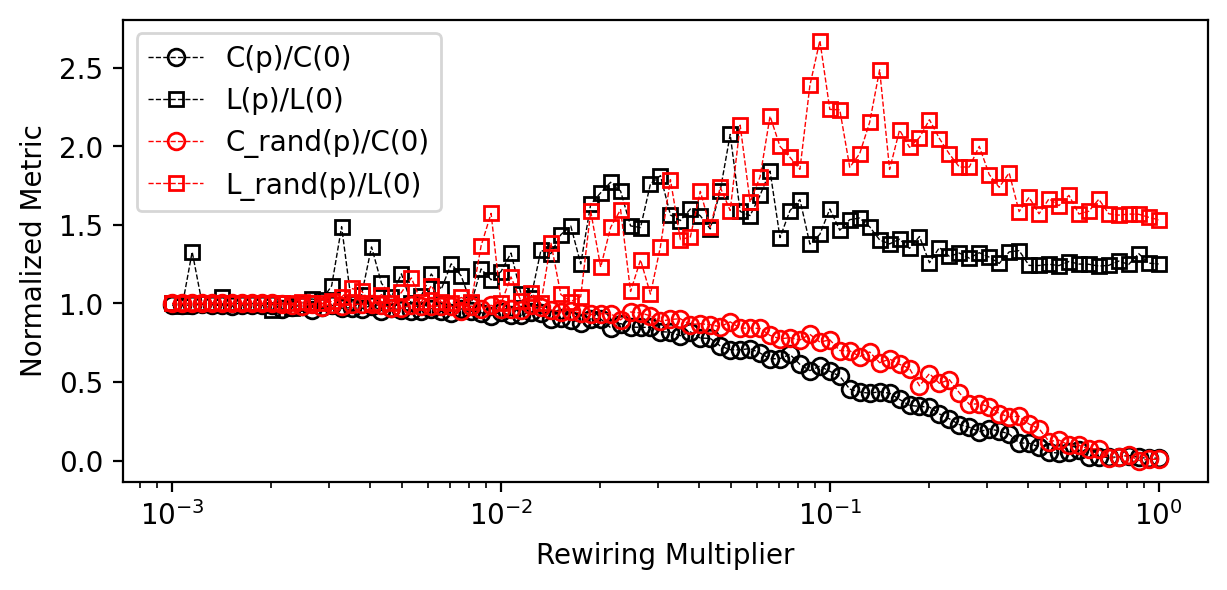

In [317]:
# plot the results
plt.figure(figsize=(7, 3))
plt.plot(nms, c, marker='o', label="C(p)/C(0)", color='black', linestyle='--', linewidth=0.5, markersize=6, mfc='None')
plt.plot(nms, l, marker='s', label="L(p)/L(0)", color='black', linestyle='--', linewidth=0.5, markersize=5, mfc='None')
plt.plot(nms, c_r, marker='o', label="C_rand(p)/C(0)", color='red', linestyle='--', linewidth=0.5, markersize=6, mfc='None')
plt.plot(nms, l_r, marker='s', label="L_rand(p)/L(0)", color='red', linestyle='--', linewidth=0.5, markersize=5, mfc='None')
plt.xscale("log")
plt.xlabel("Rewiring Multiplier")
plt.ylabel("Normalized Metric")
plt.legend()


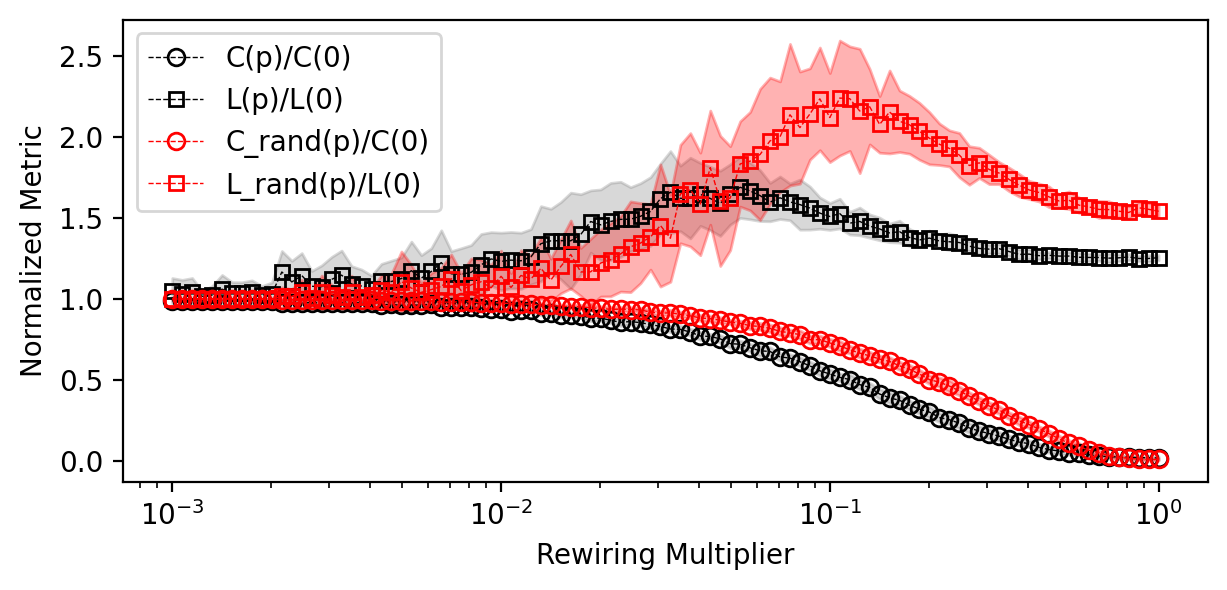

In [320]:
mean_l = np.mean(l_list, axis=0)
mean_c = np.mean(c_list, axis=0)
mean_l_r = np.mean(l_r_list, axis=0)
mean_c_r = np.mean(c_r_list, axis=0)
sd_l = np.std(l_list, axis=0)
sd_c = np.std(c_list, axis=0)
sd_l_r = np.std(l_r_list, axis=0)
sd_c_r = np.std(c_r_list, axis=0)
# plot the results
plt.figure(figsize=(7, 3))
plt.plot(nms, mean_c, marker='o', label="C(p)/C(0)", color='black', linestyle='--', linewidth=0.5, markersize=6, mfc='None')
plt.plot(nms, mean_l, marker='s', label="L(p)/L(0)", color='black', linestyle='--', linewidth=0.5, markersize=5, mfc='None')
plt.plot(nms, mean_c_r, marker='o', label="C_rand(p)/C(0)", color='red', linestyle='--', linewidth=0.5, markersize=6, mfc='None')
plt.plot(nms, mean_l_r, marker='s', label="L_rand(p)/L(0)", color='red', linestyle='--', linewidth=0.5, markersize=5, mfc='None')
# plot standard deviation as grey area
plt.fill_between(nms, mean_c - sd_c, mean_c + sd_c, color='grey', alpha=0.3)
plt.fill_between(nms, mean_l - sd_l, mean_l + sd_l, color='grey', alpha=0.3)
plt.fill_between(nms, mean_c_r - sd_c_r, mean_c_r + sd_c_r, color='red', alpha=0.3)
plt.fill_between(nms, mean_l_r - sd_l_r, mean_l_r + sd_l_r, color='red', alpha=0.3)
plt.xscale("log")
plt.xlabel("Rewiring Multiplier")
plt.ylabel("Normalized Metric")
plt.legend()


In [321]:
np.save("mean_l_2004.npy", mean_l)
np.save("mean_c_2004.npy", mean_c)
np.save("mean_l_r_2004.npy", mean_l_r)
np.save("mean_c_r_2004.npy", mean_c_r)
np.save("sd_l_2004.npy", sd_l)
np.save("sd_c_2004.npy", sd_c)
np.save("sd_l_r_2004.npy", sd_l_r)
np.save("sd_c_r_2004.npy", sd_c_r)


In [257]:
G.number_of_edges(), G_rand.number_of_edges()

(2131, 2131)

In [203]:
domains = []
for work in w_um:
    if work["primary_topic"] is not None:
        if work["primary_topic"]["domain"] is not None:
            domains.append(work["primary_topic"]["domain"]["display_name"])     
#w_um[10]["primary_topic"]["domain"]["display_name"]

In [204]:
set(domains)

{'Health Sciences', 'Life Sciences', 'Physical Sciences', 'Social Sciences'}

In [301]:
np.random.seed()

In [322]:
25/135

0.18518518518518517

In [323]:
32/135

0.23703703703703705

In [324]:
48/135

0.35555555555555557